In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave
from tqdm import tqdm

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam,Adagrad
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from math import sqrt
from keras.callbacks import History 
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, merge
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
import keras.backend as K
from math import sqrt
from keras.callbacks import History 
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataPath = '/home/rsk/Documents/UPenn/DymaxionLabs/SlumPatches/Patches'

In [3]:
def read_img(filepath, size,grayscale=False):
    
    if grayscale:
        img = image.load_img((filepath), target_size=size,grayscale=True)
        img = image.img_to_array(img,data_format='channels_last')
    else:
        img = image.load_img((filepath), target_size=size)
        img = image.img_to_array(img,data_format='channels_last')
    return img

In [4]:
%run '/home/rsk/Documents/UPenn/DymaxionLabs/Modeling/util.py'


In [5]:
imgSize = (256,256)
batchSize = 6

In [6]:
smooth = 1.

def dice_coef(y_true, y_pred):
#     y_true_f = K.greater(K.flatten(y_true),0.5)
#     y_pred_f = K.greater(K.flatten(y_pred),0.5)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)


def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true,y_pred) + 0.5*(1.-dice_coef(y_true, y_pred))



### Generator

In [19]:
class Generator(keras.utils.Sequence):
    
    def __init__(self,path,folderList,invertMask = False):
        """
        invertMask : Inverts the mask image
        path : Path containing the folders for all raster files
        folderList : List of raster files that will be used by the generator for creating batches
        """
        
        self.path = path
        self.folderList = folderList
        self.invertMask = invertMask
        
        fileList = []
        
        for i in range(len(folderList)):
            files = os.listdir(os.path.join(path,folderList[i]))
            fileList += [os.path.join(path,folderList[i],x) for x in files]
            
        self.imgList = [x for x in fileList if "img" in x]  #Keeping only the RGB map images
        
        
    def __len__(self):
        
        return 30
    
    def __getitem__(self,index):
        
        pairs, targets = self.getBatch(batch_size)
        
        return pairs, targets
        

     
        

    def getBatch(self,batchSize):
              
        imgs=[]
        masks=[]
        
        selections = np.random.choice(len(self.imgList),batchSize,replace=False)
        
        for i in range(batchSize):
            
            img = read_img(self.imgList[selections[i]],imgSize)
            
            maskFileName = self.imgList[selections[i]].replace("img","mask")
            
            mask = read_img(maskFileName,imgSize,grayscale=True)
            mask = mask/255.0
            
            imgs.append(img/255.0)
            
            if self.invertMask:
                mask = invertMask(mask)
                
            
            masks.append(mask.reshape(mask.shape[0],mask.shape[1],1))
        
        imgs = np.array(imgs)
        masks = np.array(masks)
            
          

        return( imgs, masks)
    
    def on_epoch_end(self):
        'Updates to be done after each epoch'
        a = 5
        
        
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.getBatch(batch_size)
            yield (pairs, targets)

### Model

#### Model 1

In [176]:

inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef])
# model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: U

#### Model 2

In [189]:

inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef,'accuracy'])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: U

#### Model 3

In [7]:

inputs = Input((256,256,3))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

bn2 = BatchNormalization()(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

bn3 = BatchNormalization()(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

bn4 = BatchNormalization()(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = Adam(lr = 1e-4), loss = binary_crossentropy, metrics = [dice_coef,'accuracy'])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py

#### Model 4

In [69]:

inputs = Input((256,256,3))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
drop1 = Dropout(0.3)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

bn2 = BatchNormalization()(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn2)
drop2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

bn3 = BatchNormalization()(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn3)
drop3 = Dropout(0.3)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

bn4 = BatchNormalization()(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
drop8 = Dropout(0.4)(conv8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
drop9 = Dropout(0.4)(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.compile(optimizer = Adam(lr = 1e-4), loss = binary_crossentropy, metrics = [dice_coef,'accuracy'])
model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef,'accuracy'])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:41: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:48: U

#### Model run

In [70]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 3)  12          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 256, 256, 64) 1792        batch_normalization_18[0][0]     
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 256, 256, 64) 0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [71]:
trainFolders = ['17JUN10140042_P003_R2C2','16AUG22134016_P004_R1C1','17JAN07134545_P002_R2C1']
testFolders = ['17JUN10140042_P003_R1C1']

In [72]:
gen = Generator(dataPath,trainFolders,invertMask=True)
testGen  = Generator(dataPath,testFolders,invertMask = True)

In [73]:
epochs=5

In [74]:
model.fit_generator(gen.generate(5),epochs=epochs,verbose=1,validation_data=testGen.generate(5),validation_steps = 5,steps_per_epoch = 100)

Epoch 1/5
100/100 [==============================] - 87s 870ms/step - loss: 0.5725 - dice_coef: 0.4275 - acc: 0.8561 - val_loss: 0.7793 - val_dice_coef: 0.2207 - val_acc: 0.7841
Epoch 2/5
100/100 [==============================] - 90s 902ms/step - loss: 0.5126 - dice_coef: 0.4874 - acc: 0.8120 - val_loss: 0.6358 - val_dice_coef: 0.3642 - val_acc: 0.8399
Epoch 3/5
100/100 [==============================] - 93s 932ms/step - loss: 0.4765 - dice_coef: 0.5235 - acc: 0.8114 - val_loss: 0.7802 - val_dice_coef: 0.2198 - val_acc: 0.8510
Epoch 4/5
100/100 [==============================] - 94s 943ms/step - loss: 0.4339 - dice_coef: 0.5661 - acc: 0.8463 - val_loss: 0.8669 - val_dice_coef: 0.1331 - val_acc: 0.8128
Epoch 5/5
100/100 [==============================] - 97s 969ms/step - loss: 0.4034 - dice_coef: 0.5966 - acc: 0.8805 - val_loss: 0.8448 - val_dice_coef: 0.1552 - val_acc: 0.8476


In [60]:
model.save("./Models/model_id2.hdf5")

In [69]:
model1 = keras.models.load_model("./Models/model_id2.hdf5", custom_objects={'dice_coef':dice_coef})

### Testing

In [75]:
def evaluateImage(generator):
    
    img,mask = generator.generate(1).next()
    
    pred = model.predict(img)
    scores = model.evaluate(img,mask)
    print("Model scores : {}".format(scores))
    print("Predicted entropy : {}".format(getCrossEntropy(mask=mask,pred=pred)))
    print("Predicted mask : {}".format(getDice(mask,pred)))
    
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title("Pred")
    plt.imshow(pred.reshape(256,256),cmap='gray')
    
    plt.subplot(132)
    plt.title("Truth Mask")
    plt.imshow(mask.reshape(256,256),cmap='gray')
    
    plt.subplot(133)
    plt.title("Original Image")
    plt.imshow(img[:,:,:].reshape(256,256,3))
    
    return(pred,mask,img)
    
    
    

1/1 [==============================] - 0s 50ms/step
Model scores : [0.9129115343093872, 0.08708846569061279, 0.8018798828125]
Predicted entropy : 0.872498312825
Predicted mask : 0.0870884734498


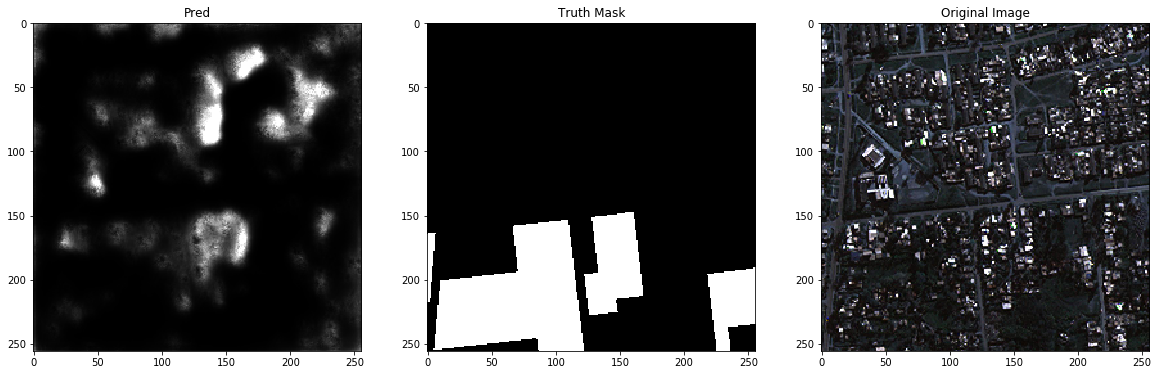

In [79]:
pred,mask,img = evaluateImage(testGen)

In [65]:
binaryMask = toBinary(mask)
pd.Series(binaryMask.reshape(-1)).value_counts()

0.0    60277
1.0     5259
dtype: int64

In [166]:
pd.Series(binaryMask.reshape(-1)).value_counts()

1.0    61846
0.0     3690
dtype: int64

In [167]:
binaryPred = toBinary(pred)
pd.Series(binaryPred.reshape(-1)).value_counts()

1.0    63269
0.0     2267
dtype: int64

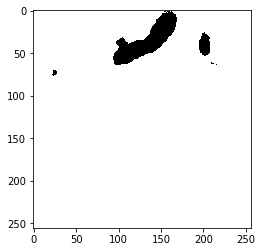

In [179]:
plt.imshow(binaryPred.reshape((256,256)),cmap='gray')

In [176]:
getDice(binaryMask,binaryPred)

0.9815930816202564

In [185]:
mask1 = invertMask(binaryMask)
pred1 = invertMask(binaryPred)

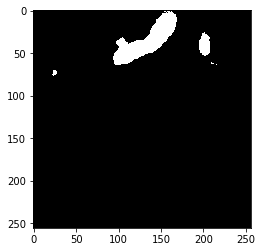

In [186]:
plt.imshow(pred1.reshape((256,256)),cmap='gray')

In [183]:
pd.Series(pred1.reshape(-1)).value_counts()

1.0    63269
0.0     2267
dtype: int64

In [187]:
getDice(mask1,pred1)

0.6134608929170863